# Capstone Analysis


# Index
- [Capstone Objectives](#Capstone-Objectives)
- [Read in Data](#Read-in-Data)
    - [Merge 2018 and 2019](#Merge-2018-and-2019)
    - [Make advisor dictionary mapper](#Make-advisor-dictionary-mapper)
- [Data Cleaning](#Data-Cleaning)
    - [Train-Test-Split](#Train-Test-Split)
    - [Custom Cleaning Functions](#Custom-Cleaning-Functions)
    - [Create Cleaning Pipeline](#Create-Cleaning-Pipeline)
- [Model building](#Model-building)
- [Make predictions](#Make-predictions)
    - [Regression](#Regression)
        - [Make Function to output deciles](#Make-Function-to-output-deciles)
    - [Classification](#Classification)
        - [Balance the data with `imbalanced-learn`](#Balance-the-data-with-imbalanced-learn)
    - [Model Interpretation](#Model-Interpretation)
- [Scratch Work](#Scratch-Work)
    - [Feature Engineering](#Feature-Engineering)
        - [Variable Inflation Factor (VIF)](#Variable-Inflation-Factor-(VIF))
    - [Residuals](#Residuals)
    - [Condition number](#Condition-number)

# Capstone Objectives
- Assist sales and marketing by improving their targeting
- Predict sales for 2019 using the data for 2018
- Estimate the probability of adding a new fund in 2019

In [569]:
import numpy as np
import pandas as pd
from pandas import Grouper
import matplotlib.pyplot as plt
import math


from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
import sklearn.metrics
from sklearn.linear_model import LogisticRegression

import seaborn as sns


pd.set_option('display.max_columns', 50)

In [570]:
df18 = pd.read_excel(r'C:\Users\prade\Desktop\Emeritus\Capstone Assignment - Nuveen Sales Data Analysis/Transaction Data.xlsx', sheet_name="Transactions18")
df19 = pd.read_excel(r'C:\Users\prade\Desktop\Emeritus\Capstone Assignment - Nuveen Sales Data Analysis/Transaction Data.xlsx', sheet_name="Transactions19")
firm = pd.read_excel(r'C:\Users\prade\Desktop\Emeritus\Capstone Assignment - Nuveen Sales Data Analysis/Firm Information.xlsx', sheet_name="Rep summary")


# Merge 2018 and 2019

In [571]:
df = pd.merge(
    df18, 
    df19, 
    on='CONTACT_ID',
    suffixes=['_2018', '_2019']
)
print(df.shape)

(10005, 41)


In [572]:
# feature names as a list
col = df18.columns       # .columns gives columns names in data 
print(col)

Index(['CONTACT_ID', 'no_of_sales_12M_1', 'no_of_Redemption_12M_1',
       'no_of_sales_12M_10K', 'no_of_Redemption_12M_10K',
       'no_of_funds_sold_12M_1', 'no_of_funds_redeemed_12M_1',
       'no_of_fund_sales_12M_10K', 'no_of_funds_Redemption_12M_10K',
       'no_of_assetclass_sold_12M_1', 'no_of_assetclass_redeemed_12M_1',
       'no_of_assetclass_sales_12M_10K', 'no_of_assetclass_Redemption_12M_10K',
       'No_of_fund_curr', 'No_of_asset_curr', 'AUM', 'sales_curr', 'sales_12M',
       'redemption_curr', 'redemption_12M', 'new_Fund_added_12M',
       'aum_AC_EQUITY', 'aum_AC_FIXED_INCOME_MUNI',
       'aum_AC_FIXED_INCOME_TAXABLE', 'aum_AC_MONEY', 'aum_AC_MULTIPLE',
       'aum_AC_PHYSICAL_COMMODITY', 'aum_AC_REAL_ESTATE', 'aum_AC_TARGET',
       'aum_P_529', 'aum_P_ALT', 'aum_P_CEF', 'aum_P_ETF', 'aum_P_MF',
       'aum_P_SMA', 'aum_P_UCITS', 'aum_P_UIT', 'refresh_date'],
      dtype='object')


# Make advisor dictionary mapper

In [573]:
adviser_lookup = {idx: contact_id for idx, contact_id in enumerate(df['CONTACT_ID'])}

In [574]:
adviser_lookup[9998]

'0318567'

# Data Cleaning

In [575]:
# make a variable to keep all of the columns we want to drop
COLS_TO_DROP = [
    'refresh_date_2019', 
    'refresh_date_2018', 
    'CONTACT_ID', 
    'aum_AC_EQUITY', 
    'aum_AC_REAL_ESTATE', 
    'no_of_funds_sold_12M_1',
    'no_of_sales_12M_1', 
    'no_of_Redemption_12M_1', 
    'no_of_funds_redeemed_12M_1', 
    'no_of_assetclass_sold_12M_1',
    'no_of_assetclass_redeemed_12M_1', 
    'aum_AC_FIXED_INCOME_TAXABLE', 
                 'aum_AC_MONEY', 
                 'aum_AC_MULTIPLE',
                 'aum_AC_PHYSICAL_COMMODITY',  
                 'aum_AC_TARGET',    
                 'aum_P_UCITS', 
                 'aum_P_529', 
                 'aum_P_ALT', 
                 'aum_P_CEF', 
                 'aum_P_ETF',    
]

COLS_TO_KEEP = [                  
                 'no_of_sales_12M_10K',
                 'no_of_Redemption_12M_10K',                  
                 'no_of_fund_sales_12M_10K',
                 'no_of_funds_Redemption_12M_10K',                 
                 'no_of_assetclass_sales_12M_10K',
                 'no_of_assetclass_Redemption_12M_10K', 
                 'AUM', 
                 'No_of_fund_curr',
                 'No_of_asset_curr',  
                 'sales_curr', 
                 'sales_12M_2018',
                 'redemption_curr', 
                 'redemption_12M', 
                 'new_Fund_added_12M_2018',
                 'aum_AC_FIXED_INCOME_MUNI', 
                 'aum_P_MF',
                 'aum_P_SMA', 
                 'aum_P_UIT'
]

FIRM_COLS = ['Contact ID', 'Channel','Sub channel',]

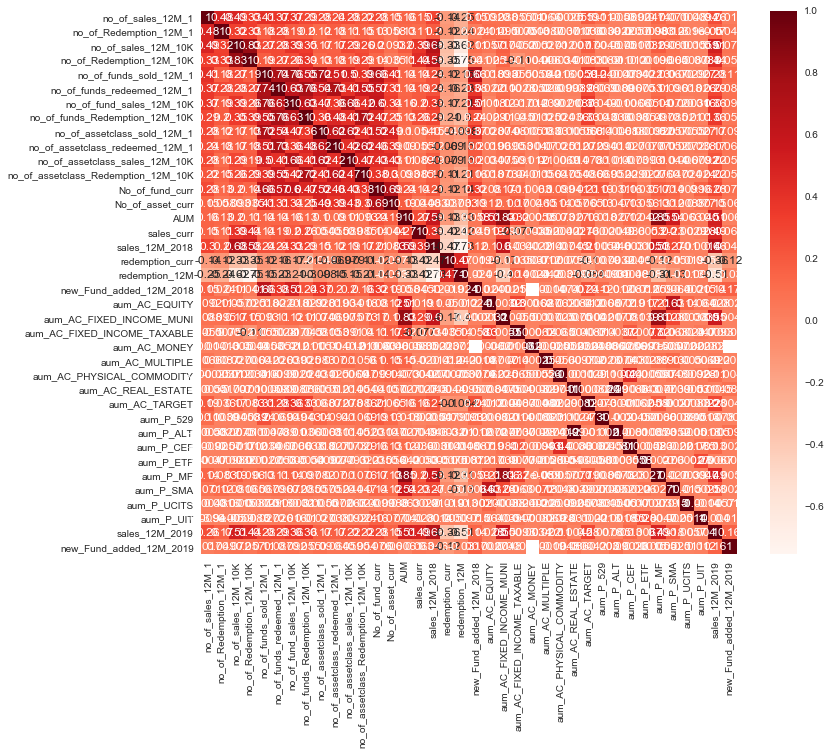

In [576]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

# Make Firm data pipeline

In [577]:
firm_lookup = {idx: contact_id for idx, contact_id in enumerate(firm['Contact ID'])}

In [578]:
firm_merged = pd.merge(df, firm, left_on="CONTACT_ID", right_on='Contact ID')
firm_merged.head(5)

,CONTACT_ID,no_of_sales_12M_1,no_of_Redemption_12M_1,no_of_sales_12M_10K,no_of_Redemption_12M_10K,no_of_funds_sold_12M_1,no_of_funds_redeemed_12M_1,no_of_fund_sales_12M_10K,no_of_funds_Redemption_12M_10K,no_of_assetclass_sold_12M_1,no_of_assetclass_redeemed_12M_1,no_of_assetclass_sales_12M_10K,no_of_assetclass_Redemption_12M_10K,No_of_fund_curr,No_of_asset_curr,AUM,sales_curr,sales_12M_2018,redemption_curr,redemption_12M,new_Fund_added_12M_2018,aum_AC_EQUITY,aum_AC_FIXED_INCOME_MUNI,aum_AC_FIXED_INCOME_TAXABLE,aum_AC_MONEY,aum_AC_MULTIPLE,aum_AC_PHYSICAL_COMMODITY,aum_AC_REAL_ESTATE,aum_AC_TARGET,aum_P_529,aum_P_ALT,aum_P_CEF,aum_P_ETF,aum_P_MF,aum_P_SMA,aum_P_UCITS,aum_P_UIT,refresh_date_2018,sales_12M_2019,new_Fund_added_12M_2019,refresh_date_2019,Contact ID,CustomerID,Firm ID,Office ID,Channel,Sub channel,Firm name
0,0047433,21.0,38.0,NaN,1.0,5.0,5.0,NaN,1.0,2.0,2.0,NaN,1.0,8.0,1.0,237480.11,250.0,19682.0,-1496.745,-102496.165,NaN,-47342.32,284737.93,84.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,122866.04,114614.07,0.0,0.0,2018-12-31,18633.105,NaN,2019-12-31,0047433,240,1688552,85101152293608716061,National Broker-Dealer,NACS,"UBS Financial Services, Inc."
1,4461312,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,19629.00,NaN,NaN,NaN,NaN,NaN,0.00,19629.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19629.00,0.00,0.0,0.0,2018-12-31,NaN,NaN,2019-12-31,4461312,4970,85202161074527509544,17754050965,Dual,IBD,Charles Schwab Investor Services
2,4491079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1758.70,NaN,NaN,NaN,NaN,NaN,0.00,1758.70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1758.70,0.00,0.0,0.0,2018-12-31,NaN,NaN,2019-12-31,4491079,5612,1655890,85102103583371489832,Independent Dealer,RIA,The O.N. Equity Sales Company
3,0107408,20.0,NaN,2.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,1.0,57943.00,5459.0,52484.0,NaN,NaN,1.0,0.00,0.00,57943.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57943.00,0.00,0.0,0.0,2018-12-31,93212.000,1.0,2019-12-31,0107408,543,0033509,85102113063786149939,Independent Dealer,IBD,"Northwestern Mutual Investment Services, LLC"
4,85101140503769936458,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8573.59,NaN,NaN,NaN,NaN,NaN,-8573.59,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-8573.59,0.00,0.0,0.0,2018-12-31,NaN,NaN,2019-12-31,85101140503769936458,7398,1092180,85201140503766736151,Independent Dealer,RIA,"Berthel, Fisher & Co. Financial Services, Inc."


In [579]:
firm_merged[FIRM_COLS]

,Contact ID,Channel,Sub channel
0,0047433,National Broker-Dealer,NACS
1,4461312,Dual,IBD
2,4491079,Independent Dealer,RIA
3,0107408,Independent Dealer,IBD
4,85101140503769936458,Independent Dealer,RIA
...,...,...,...
10000,4354749,Independent Dealer,IBD
10001,85202110743700895498,Independent Dealer,IBD
10002,85101153615072327284,National Broker-Dealer,NACS
10003,4486975,Fee-Based Adviser,IBD


# Do rest of Pipeline

In [580]:
X = df.drop(['sales_12M_2019', 'new_Fund_added_12M_2019'], axis=1)
y_reg = df['sales_12M_2019']
y_cl = df['new_Fund_added_12M_2019']

In [581]:
y_reg.isnull().value_counts()

False    5074
True     4931
Name: sales_12M_2019, dtype: int64

In [582]:
X_train, X_test, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.25, random_state=24, stratify=y_reg.isnull())
y_train_cl, y_test_cl = y_cl[y_train_reg.index], y_cl[y_test_reg.index]

In [583]:
y_train_reg.isnull().value_counts(normalize=True)

False    0.50713
True     0.49287
Name: sales_12M_2019, dtype: float64

In [584]:
y_test_reg.isnull().value_counts(normalize=True)

False    0.507194
True     0.492806
Name: sales_12M_2019, dtype: float64

# Custom Cleaning Functions

In [585]:
def extract_columns(df):
    '''extract out columns not listed in COLS_TO_DROP variable'''
    cols_to_keep = [col for col in df.columns if col not in COLS_TO_DROP]
    return df.loc[:, cols_to_keep].copy()

def fillna_values(df):
    '''fill nan values with zero'''
    if isinstance(df, type(pd.Series(dtype='float64'))):
        return df.fillna(0)
    elif isinstance(df, type(pd.DataFrame())):
        num_df = df.select_dtypes(include=['number']).fillna(0)
        non_num_df = df.select_dtypes(exclude=['number'])
        return pd.concat([num_df, non_num_df], axis=1)
    else:
        return np.nan_to_num(df)

def negative_to_zero(series):
    '''fill negative values to zero'''
    if isinstance(series, type(pd.Series(dtype='float64'))):
        return series.apply(lambda x: max(0, x))
    else:
        return series
    
def bin_y_class(series):
    series = series.apply(lambda x: 1 if x >=1 else 0)
    return series

cat_cols = list(X_train.select_dtypes(include=['object']).columns)
def dummy_col_adder(array):
    dummy_cols = []
    for col, cat_set in zip(cat_cols, feat_pipe.named_steps['OneHotEncoder'].categories_):
        for cat in cat_set:
            dummy_cols.append(col+'_'+str(cat))
    return pd.DataFrame(array, columns=dummy_cols)
# dummy_col_transformer = FunctionTransformer(dummy_col_adder, validate=False)

# Create Cleaning Pipeline

Convert functions to transformers

In [586]:
extract_columns_trans = FunctionTransformer(extract_columns)
fillna_values_trans = FunctionTransformer(fillna_values)
negative_to_zero_trans = FunctionTransformer(negative_to_zero)
bin_y_class_trans = FunctionTransformer(bin_y_class)

Make pipeline for target variables

In [587]:
reg_targ_pipe = Pipeline([
    ('fillna_values_trans', fillna_values_trans),
    ('negative_to_zero', negative_to_zero_trans),
])

class_targ_pipe = Pipeline([
    ('fillna_values_trans', fillna_values_trans),
    ('bin_y_class_trans', bin_y_class_trans),
])

Fit and transform TRAINING

In [588]:
y_train_reg = reg_targ_pipe.fit_transform(y_train_reg)
y_train_cl = class_targ_pipe.fit_transform(y_train_cl)

Transform only TESTING

In [589]:
y_test_reg = reg_targ_pipe.transform(y_test_reg) 
y_test_cl = class_targ_pipe.transform(y_test_cl)

In [590]:
y_test_cl.value_counts()

0    1861
1     641
Name: new_Fund_added_12M_2019, dtype: int64

Make pipeline for features

In [591]:
ss = StandardScaler()
ss.fit_transform(X_train[['no_of_sales_12M_10K', 'AUM']].fillna(0), y_train_reg)

array([[-0.21315855, -0.10350306],
       [-0.21315855,  0.00522776],
       [-0.21315855, -0.10350306],
       ...,
       [-0.21315855, -0.10554775],
       [-0.21315855, -0.10413842],
       [-0.21315855, -0.10033432]])

In [592]:
ss.transform(X_train[['no_of_sales_12M_10K', 'AUM']].fillna(0))

array([[-0.21315855, -0.10350306],
       [-0.21315855,  0.00522776],
       [-0.21315855, -0.10350306],
       ...,
       [-0.21315855, -0.10554775],
       [-0.21315855, -0.10413842],
       [-0.21315855, -0.10033432]])

In [593]:
ss.transform(X_test[['no_of_sales_12M_10K', 'AUM']].fillna(0))

array([[-0.21315855, -2.34289094],
       [-0.21315855, -0.09841378],
       [-0.21315855, -0.09892631],
       ...,
       [ 0.68746573, -0.0417792 ],
       [-0.03303369, -0.16446575],
       [-0.21315855, -0.26290745]])

In [594]:
feat_pipe = Pipeline([
    ('extract_columns_trans', extract_columns_trans),
    ('fillna_values_trans', fillna_values_trans),
    ('StandardScaler', StandardScaler()),
])

# fit and transform TRAINING
train_array = feat_pipe.fit(X_train, y_train_reg).transform(X_train)

train_array

# Give training data row and column labels back
X_train_prepared = pd.DataFrame(
    train_array,
    index=X_train.index,
    columns=COLS_TO_KEEP
)

# use FeatureUnion to run multiple pipelines at once

In [595]:
X_train_prepared.head(2)

,no_of_sales_12M_10K,no_of_Redemption_12M_10K,no_of_fund_sales_12M_10K,no_of_funds_Redemption_12M_10K,no_of_assetclass_sales_12M_10K,no_of_assetclass_Redemption_12M_10K,AUM,No_of_fund_curr,No_of_asset_curr,sales_curr,sales_12M_2018,redemption_curr,redemption_12M,new_Fund_added_12M_2018,aum_AC_FIXED_INCOME_MUNI,aum_P_MF,aum_P_SMA,aum_P_UIT
3016,-0.213159,-0.202310,-0.431731,-0.451524,-0.539912,-0.566298,-0.688081,-0.887018,-0.103503,-0.087693,-0.158849,0.090594,0.151819,-0.412074,-0.090999,-0.065685,-0.074575,-0.069496
2569,-0.213159,-0.092965,-0.431731,0.284471,-0.539912,0.770265,1.221427,3.897522,0.005228,-0.087693,-0.143764,0.041500,0.123349,0.418829,-0.064646,-0.070373,0.157046,0.002049


TRANSFORM the test set (Do NOT fit the pipeline on testing!)

In [596]:
X_test_prepared = pd.DataFrame(
    feat_pipe.transform(X_test),
    index=X_test.index,
    columns=COLS_TO_KEEP
)

In [597]:
y_train_reg.head()

3016    3.792140e+06
2569    5.656385e+05
2189    5.481458e+04
1166    7.762492e+05
959     0.000000e+00
Name: sales_12M_2019, dtype: float64

# Model building

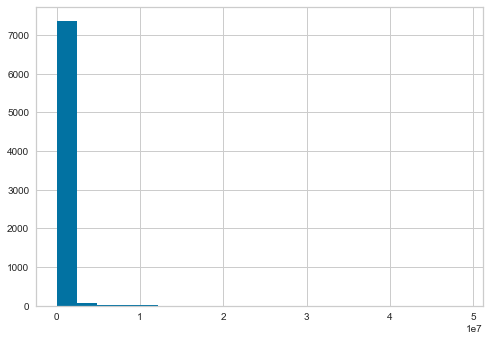

In [598]:
y_train_reg.hist(bins=20);

In [599]:
np.exp(np.log(y_train_reg+1))

3016    3.792141e+06
2569    5.656395e+05
2189    5.481558e+04
1166    7.762502e+05
959     1.000000e+00
            ...     
719     1.000000e+00
3975    2.223641e+06
9721    1.000000e+00
7684    8.350100e+04
1604    1.375100e+04
Name: sales_12M_2019, Length: 7503, dtype: float64

In [600]:
from sklearn.linear_model import RidgeCV
from sklearn.compose import TransformedTargetRegressor

In [601]:
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import RandomizedSearchCV
# import xgboost as xgb

In [602]:
def modified_log(x):
    x = np.where(x<0, 0, x)
    return np.log(x, where=x>0)

In [603]:
def modified_exp(x):
    x = np.where(x>15, 15, x)
    return np.expm1(x)

In [604]:
ttr = TransformedTargetRegressor(
        RidgeCV(), 
        func=np.log1p, 
        inverse_func=modified_exp, 
        check_inverse=False
)

In [605]:
ttr.fit(X_train_prepared, y_train_reg)

TransformedTargetRegressor(check_inverse=False, func=<ufunc 'log1p'>,
                           inverse_func=<function modified_exp at 0x000001C3CD17B048>,
                           regressor=RidgeCV(alphas=array([ 0.1,  1. , 10. ])))

In [606]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

In [607]:
model.fit(X_train_prepared, y_train_reg)


LinearRegression()

In [608]:
r_sq = model.score(X_train_prepared, y_train_reg)
print('coefficient of determination:', r_sq)


coefficient of determination: 0.5607276270110616


In [609]:
print('intercept:', model.intercept_)

intercept: 226592.29951753857


In [610]:
print('slope:', model.coef_)

slope: [ 1.94071668e+05  3.07534539e+04  8.17387101e+04  1.68758637e+05
 -2.85981778e+04 -1.05835642e+05  2.71855355e+04 -6.08845933e+03
  8.14295320e+05  2.30595115e+05  2.71676919e+05 -3.06650067e+04
 -3.34704567e+04  5.52362222e+02  3.39858487e+05 -6.51741883e+05
 -4.70457613e+05 -3.89684979e+04]


In [611]:
y_pred = model.predict(X_test_prepared)

In [612]:
print('predicted response:', y_pred, sep='\n')

predicted response:
[-397032.5573251    26955.55800092   30430.5130276  ...  381707.373759
   55109.23413378   11395.25725557]


# Make predictions

## Regression

In [613]:
test_preds = pd.Series(ttr.predict(X_test_prepared), index=y_test_reg.index)
test_preds

6307         4.419679
4521        29.164062
7859        51.920529
110         16.235233
4238        50.101699
            ...      
5710       937.622514
6026       146.013837
6246    173880.789981
8059     21401.848867
6438       202.714972
Length: 2502, dtype: float64

In [614]:
ttr.score(X_test_prepared, y_test_reg)

0.0179364180069298

### Make Function to output deciles

In [615]:
def output_deciles(model, X, y):
    results = pd.DataFrame(model.predict(X), index=y.index, columns=['prediction'])
    results['Actual'] = y.values
    results['Deciles'] = pd.qcut(results['prediction'], 10, labels=False)
    results['Contact_id'] = results.index.map(adviser_lookup)
    return results

In [616]:
result_df = output_deciles(ttr, X_test_prepared, y_test_reg)
result_df

,prediction,Actual,Deciles,Contact_id
6307,4.419679,0.00,0,4495550
4521,29.164062,0.00,3,85102132724913032579
7859,51.920529,0.00,5,4380705
110,16.235233,25093.00,1,85102151525164324880
4238,50.101699,742.00,5,85101111303291084757
...,...,...,...,...
5710,937.622514,0.00,7,0056157
6026,146.013837,750051.80,6,85202111474542078472
6246,173880.789981,264238.31,9,85201140523379459042
8059,21401.848867,37576.85,9,85202111325248394877


In [617]:
def output_deciles(model, X, y):
    results = pd.DataFrame(model.predict(X), index=y.index, columns=['prediction'])
    results['Actual'] = y.values
    results['Deciles'] = pd.qcut(results['prediction'], 10, labels=False)
    results['Contact_id'] = results.index.map(adviser_lookup)
    return results

In [618]:
result_df[result_df['Deciles'] == 9]

,prediction,Actual,Deciles,Contact_id
2990,1.550450e+05,7.189395e+04,9,4353864
6452,7.603348e+04,7.314998e+06,9,85202112173254510211
9406,4.883173e+05,3.403134e+04,9,0283057
9754,1.530419e+05,7.582611e+04,9,85202162243475732600
324,1.952719e+06,3.341190e+06,9,85101122913914154200
...,...,...,...,...
9405,5.180957e+04,1.621394e+04,9,85202160935784977832
7020,4.872080e+04,8.802145e+04,9,4342905
8853,1.078483e+05,9.053720e+05,9,0347664
6246,1.738808e+05,2.642383e+05,9,85201140523379459042


In [619]:
Train_Data1 = result_df[['prediction', 'Actual', 'Deciles']]
Train_Data1.head()

,prediction,Actual,Deciles
6307,4.419679,0.0,0
4521,29.164062,0.0,3
7859,51.920529,0.0,5
110,16.235233,25093.0,1
4238,50.101699,742.0,5


In [620]:
Train_Data1['Non-Defaulter'] = 1-Train_Data1['Actual']
Train_Data1.head()

,prediction,Actual,Deciles,Non-Defaulter
6307,4.419679,0.0,0,1.0
4521,29.164062,0.0,3,1.0
7859,51.920529,0.0,5,1.0
110,16.235233,25093.0,1,-25092.0
4238,50.101699,742.0,5,-741.0


In [621]:
df_n = pd.pivot_table(data=Train_Data1,index=['Deciles'],values=['Actual','Non-Defaulter','prediction'],
                     aggfunc={'Actual':[np.sum],
                              'Non-Defaulter':[np.sum],
                              'prediction' : [np.min,np.max]})
df_n.head()

Actual Non-Defaulter prediction           
                  sum           sum       amax       amin
Deciles                                                  
0        3.571829e+06 -3.571578e+06  16.234924   0.873228
1        2.146420e+07 -2.146395e+07  16.237375  16.234934
2        4.375300e+06 -4.375050e+06  16.380717  16.237377
3        5.071543e+06 -5.071293e+06  29.238467  16.384026
4        1.280214e+07 -1.280189e+07  42.541850  29.238910

In [622]:
df_n.reset_index()

Deciles        Actual Non-Defaulter    prediction              
                    sum           sum          amax          amin
0       0  3.571829e+06 -3.571578e+06  1.623492e+01      0.873228
1       1  2.146420e+07 -2.146395e+07  1.623738e+01     16.234934
2       2  4.375300e+06 -4.375050e+06  1.638072e+01     16.237377
3       3  5.071543e+06 -5.071293e+06  2.923847e+01     16.384026
4       4  1.280214e+07 -1.280189e+07  4.254185e+01     29.238910
5       5  1.037087e+07 -1.037062e+07  7.777977e+01     42.687636
6       6  3.037178e+07 -3.037153e+07  2.763774e+02     78.237156
7       7  3.814994e+07 -3.814969e+07  1.448669e+03    281.657276
8       8  6.504056e+07 -6.504031e+07  2.050202e+04   1492.183910
9       9  2.498279e+08 -2.498277e+08  3.269016e+06  21401.848867

In [623]:
df_n.columns = ['Defaulter_Count','Non-Defaulter_Count','max_score','min_score']
df_n['Total_Cust'] = df_n['Defaulter_Count']+df_n['Non-Defaulter_Count']
df_n

,Defaulter_Count,Non-Defaulter_Count,max_score,min_score,Total_Cust
Deciles,,,,,
0,3.571829e+06,-3.571578e+06,1.623492e+01,0.873228,251.0
1,2.146420e+07,-2.146395e+07,1.623738e+01,16.234934,250.0
2,4.375300e+06,-4.375050e+06,1.638072e+01,16.237377,250.0
3,5.071543e+06,-5.071293e+06,2.923847e+01,16.384026,250.0
4,1.280214e+07,-1.280189e+07,4.254185e+01,29.238910,250.0
5,1.037087e+07,-1.037062e+07,7.777977e+01,42.687636,250.0
6,3.037178e+07,-3.037153e+07,2.763774e+02,78.237156,250.0
7,3.814994e+07,-3.814969e+07,1.448669e+03,281.657276,250.0
8,6.504056e+07,-6.504031e+07,2.050202e+04,1492.183910,250.0


In [624]:
df2_n = df_n.sort_values(by='min_score',ascending=False)
df2_n

,Defaulter_Count,Non-Defaulter_Count,max_score,min_score,Total_Cust
Deciles,,,,,
9,2.498279e+08,-2.498277e+08,3.269016e+06,21401.848867,251.0
8,6.504056e+07,-6.504031e+07,2.050202e+04,1492.183910,250.0
7,3.814994e+07,-3.814969e+07,1.448669e+03,281.657276,250.0
6,3.037178e+07,-3.037153e+07,2.763774e+02,78.237156,250.0
5,1.037087e+07,-1.037062e+07,7.777977e+01,42.687636,250.0
4,1.280214e+07,-1.280189e+07,4.254185e+01,29.238910,250.0
3,5.071543e+06,-5.071293e+06,2.923847e+01,16.384026,250.0
2,4.375300e+06,-4.375050e+06,1.638072e+01,16.237377,250.0
1,2.146420e+07,-2.146395e+07,1.623738e+01,16.234934,250.0


In [625]:
df2_n['Default_Rate'] = (df2_n['Defaulter_Count'] / df2_n['Total_Cust']).apply('{0:.2%}'.format)
default_sum = df2_n['Defaulter_Count'].sum()
non_default_sum = df2_n['Non-Defaulter_Count'].sum()
df2_n['Default %'] = (df2_n['Defaulter_Count']/default_sum).apply('{0:.2%}'.format)
df2_n['Non_Default %'] = (df2_n['Non-Defaulter_Count']/non_default_sum).apply('{0:.2%}'.format)
df2_n

,Defaulter_Count,Non-Defaulter_Count,max_score,min_score,Total_Cust,Default_Rate,Default %,Non_Default %
Deciles,,,,,,,,
9,2.498279e+08,-2.498277e+08,3.269016e+06,21401.848867,251.0,99533039.07%,56.64%,56.64%
8,6.504056e+07,-6.504031e+07,2.050202e+04,1492.183910,250.0,26016225.61%,14.75%,14.75%
7,3.814994e+07,-3.814969e+07,1.448669e+03,281.657276,250.0,15259974.81%,8.65%,8.65%
6,3.037178e+07,-3.037153e+07,2.763774e+02,78.237156,250.0,12148710.01%,6.89%,6.89%
5,1.037087e+07,-1.037062e+07,7.777977e+01,42.687636,250.0,4148346.81%,2.35%,2.35%
4,1.280214e+07,-1.280189e+07,4.254185e+01,29.238910,250.0,5120857.72%,2.90%,2.90%
3,5.071543e+06,-5.071293e+06,2.923847e+01,16.384026,250.0,2028617.09%,1.15%,1.15%
2,4.375300e+06,-4.375050e+06,1.638072e+01,16.237377,250.0,1750119.99%,0.99%,0.99%
1,2.146420e+07,-2.146395e+07,1.623738e+01,16.234934,250.0,8585679.96%,4.87%,4.87%


In [626]:
df2_n['ks_stats'] = np.round(((df2_n['Defaulter_Count'] / df2_n['Defaulter_Count'].sum()).cumsum() -(df2_n['Non-Defaulter_Count'] / df2_n['Non-Defaulter_Count'].sum()).cumsum()), 4) * 100
df2_n

,Defaulter_Count,Non-Defaulter_Count,max_score,min_score,Total_Cust,Default_Rate,Default %,Non_Default %,ks_stats
Deciles,,,,,,,,,
9,2.498279e+08,-2.498277e+08,3.269016e+06,21401.848867,251.0,99533039.07%,56.64%,56.64%,-0.0
8,6.504056e+07,-6.504031e+07,2.050202e+04,1492.183910,250.0,26016225.61%,14.75%,14.75%,-0.0
7,3.814994e+07,-3.814969e+07,1.448669e+03,281.657276,250.0,15259974.81%,8.65%,8.65%,-0.0
6,3.037178e+07,-3.037153e+07,2.763774e+02,78.237156,250.0,12148710.01%,6.89%,6.89%,-0.0
5,1.037087e+07,-1.037062e+07,7.777977e+01,42.687636,250.0,4148346.81%,2.35%,2.35%,-0.0
4,1.280214e+07,-1.280189e+07,4.254185e+01,29.238910,250.0,5120857.72%,2.90%,2.90%,-0.0
3,5.071543e+06,-5.071293e+06,2.923847e+01,16.384026,250.0,2028617.09%,1.15%,1.15%,-0.0
2,4.375300e+06,-4.375050e+06,1.638072e+01,16.237377,250.0,1750119.99%,0.99%,0.99%,-0.0
1,2.146420e+07,-2.146395e+07,1.623738e+01,16.234934,250.0,8585679.96%,4.87%,4.87%,-0.0


In [627]:
flag = lambda x: '*****' if x == df2_n['ks_stats'].max() else ''
df2_n['max_ks'] = df2_n['ks_stats'].apply(flag)
df2_n

,Defaulter_Count,Non-Defaulter_Count,max_score,min_score,Total_Cust,Default_Rate,Default %,Non_Default %,ks_stats,max_ks
Deciles,,,,,,,,,,
9,2.498279e+08,-2.498277e+08,3.269016e+06,21401.848867,251.0,99533039.07%,56.64%,56.64%,-0.0,*****
8,6.504056e+07,-6.504031e+07,2.050202e+04,1492.183910,250.0,26016225.61%,14.75%,14.75%,-0.0,*****
7,3.814994e+07,-3.814969e+07,1.448669e+03,281.657276,250.0,15259974.81%,8.65%,8.65%,-0.0,*****
6,3.037178e+07,-3.037153e+07,2.763774e+02,78.237156,250.0,12148710.01%,6.89%,6.89%,-0.0,*****
5,1.037087e+07,-1.037062e+07,7.777977e+01,42.687636,250.0,4148346.81%,2.35%,2.35%,-0.0,*****
4,1.280214e+07,-1.280189e+07,4.254185e+01,29.238910,250.0,5120857.72%,2.90%,2.90%,-0.0,*****
3,5.071543e+06,-5.071293e+06,2.923847e+01,16.384026,250.0,2028617.09%,1.15%,1.15%,-0.0,*****
2,4.375300e+06,-4.375050e+06,1.638072e+01,16.237377,250.0,1750119.99%,0.99%,0.99%,-0.0,*****
1,2.146420e+07,-2.146395e+07,1.623738e+01,16.234934,250.0,8585679.96%,4.87%,4.87%,-0.0,*****


In [628]:
df_test1 = df2_n.copy()
df_test1['default_cum%'] = np.round(((df2_n['Defaulter_Count'] / df2_n['Defaulter_Count'].sum()).cumsum()), 4) * 100
df_test1

,Defaulter_Count,Non-Defaulter_Count,max_score,min_score,Total_Cust,Default_Rate,Default %,Non_Default %,ks_stats,max_ks,default_cum%
Deciles,,,,,,,,,,,
9,2.498279e+08,-2.498277e+08,3.269016e+06,21401.848867,251.0,99533039.07%,56.64%,56.64%,-0.0,*****,56.64
8,6.504056e+07,-6.504031e+07,2.050202e+04,1492.183910,250.0,26016225.61%,14.75%,14.75%,-0.0,*****,71.39
7,3.814994e+07,-3.814969e+07,1.448669e+03,281.657276,250.0,15259974.81%,8.65%,8.65%,-0.0,*****,80.04
6,3.037178e+07,-3.037153e+07,2.763774e+02,78.237156,250.0,12148710.01%,6.89%,6.89%,-0.0,*****,86.93
5,1.037087e+07,-1.037062e+07,7.777977e+01,42.687636,250.0,4148346.81%,2.35%,2.35%,-0.0,*****,89.28
4,1.280214e+07,-1.280189e+07,4.254185e+01,29.238910,250.0,5120857.72%,2.90%,2.90%,-0.0,*****,92.18
3,5.071543e+06,-5.071293e+06,2.923847e+01,16.384026,250.0,2028617.09%,1.15%,1.15%,-0.0,*****,93.33
2,4.375300e+06,-4.375050e+06,1.638072e+01,16.237377,250.0,1750119.99%,0.99%,0.99%,-0.0,*****,94.32
1,2.146420e+07,-2.146395e+07,1.623738e+01,16.234934,250.0,8585679.96%,4.87%,4.87%,-0.0,*****,99.19


In [629]:
df_test2 = df_test1[['default_cum%']]
df_test2.reset_index()
df_test2.columns = ['default_cum%_test']
df_test2

,default_cum%_test
Deciles,
9,56.64
8,71.39
7,80.04
6,86.93
5,89.28
4,92.18
3,93.33
2,94.32
1,99.19


In [630]:
df_train = df_test1[['Non_Default %']]
df_train.reset_index()
df_train.columns = ['default_cum%_train']
df_train2 = df_train.copy()
df_train2['Base %'] = [10,20,30,40,50,60,70,80,90,100]
df_train2

,default_cum%_train,Base %
Deciles,,
9,56.64%,10
8,14.75%,20
7,8.65%,30
6,6.89%,40
5,2.35%,50
4,2.90%,60
3,1.15%,70
2,0.99%,80
1,4.87%,90


In [631]:
final = pd.concat([df_train2,df_test2],axis=1)
final

,default_cum%_train,Base %,default_cum%_test
Deciles,,,
9,56.64%,10,56.64
8,14.75%,20,71.39
7,8.65%,30,80.04
6,6.89%,40,86.93
5,2.35%,50,89.28
4,2.90%,60,92.18
3,1.15%,70,93.33
2,0.99%,80,94.32
1,4.87%,90,99.19


Text(0.5, 1.0, 'Gains Chart')

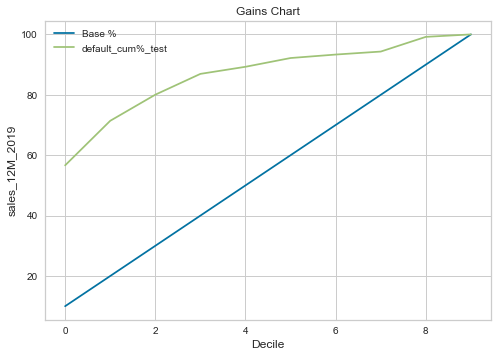

In [632]:
gains_chart = final.plot(kind='line',use_index=False)
gains_chart.set_ylabel("sales_12M_2019",fontsize=12)
gains_chart.set_xlabel("Decile",fontsize=12)
gains_chart.set_title("Gains Chart")

# Classification

In [633]:
y_train_cl.head()

3016    1
2569    1
2189    1
1166    0
959     0
Name: new_Fund_added_12M_2019, dtype: int64

In [634]:
from sklearn.ensemble import GradientBoostingClassifier

In [635]:
gbt_base = GradientBoostingClassifier()
gbt_base.fit(X_train_prepared, y_train_cl)
test_pred_class = gbt_base.predict(X_test_prepared)
print(classification_report(y_test_cl, test_pred_class))

              precision    recall  f1-score   support

           0       0.76      0.96      0.85      1861
           1       0.46      0.09      0.16       641

    accuracy                           0.74      2502
   macro avg       0.61      0.53      0.50      2502
weighted avg       0.68      0.74      0.67      2502



In [636]:
def output_deciles_class(model, X, y):
    results = pd.DataFrame(model.predict_proba(X)[:,1], index=y.index, columns=['prediction'])
    results['actual'] = y.values
    results['deciles'] = pd.qcut(results['prediction'], 10, labels=False)
    results['contact_id'] = results.index.map(adviser_lookup)
    return results.sort_values(by='prediction', ascending=False)

In [637]:
output_deciles_class(gbt_base, X_train_prepared, y_train_cl)

,prediction,actual,deciles,contact_id
1783,0.970280,1,9,85101103674323007541
5035,0.958633,1,9,4316840
4247,0.952502,1,9,0000508
6867,0.952478,1,9,0232384
7208,0.936176,1,9,0337135
...,...,...,...,...
8335,0.060908,0,0,85101123395951043347
4719,0.060728,0,0,4443862
983,0.060728,0,0,0123140
2047,0.055556,0,0,4352526


### Balance the data with imbalanced-learn

In [638]:
from imblearn.over_sampling import SMOTE

In [639]:
# instantiate SMOTENC
smote = SMOTE(random_state=0)

# balance data
X_smote, y_smote = smote.fit_resample(X_train_prepared, y_train_cl)

In [640]:
y_smote.value_counts()

1    5623
0    5623
Name: new_Fund_added_12M_2019, dtype: int64

In [641]:
gbt_base2 = GradientBoostingClassifier()
gbt_base2.fit(X_smote, y_smote)
test_pred_class2 = gbt_base2.predict(X_test_prepared)
print(classification_report(y_test_cl, test_pred_class2))

              precision    recall  f1-score   support

           0       0.83      0.73      0.78      1861
           1       0.42      0.58      0.49       641

    accuracy                           0.69      2502
   macro avg       0.63      0.65      0.63      2502
weighted avg       0.73      0.69      0.70      2502



In [642]:
log_model = LogisticRegression()

In [643]:
log_model.fit(X_train_prepared,y_train_cl)

LogisticRegression()

In [644]:
pred_log = log_model.predict(X_test_prepared)

In [645]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_test_cl,pred_log)
cm

array([[1808,   53],
       [ 595,   46]], dtype=int64)

Text(0.5, 29.5, 'Predicted Values')

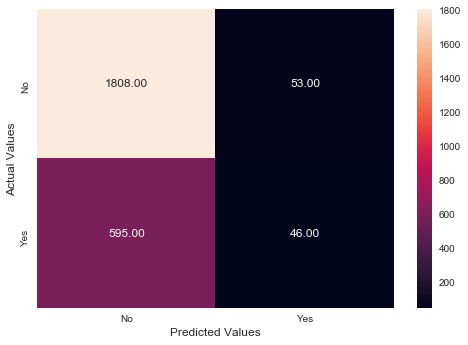

In [646]:
import seaborn as sn
sn.heatmap(cm, annot=True,  fmt='.2f', xticklabels = ["No", "Yes"] , yticklabels = ["No", "Yes"],)
plt.ylabel('Actual Values',fontsize=12)
plt.xlabel('Predicted Values',fontsize=12)

In [647]:
print(metrics.classification_report(y_test_cl,pred_log,digits=2))

              precision    recall  f1-score   support

           0       0.75      0.97      0.85      1861
           1       0.46      0.07      0.12       641

    accuracy                           0.74      2502
   macro avg       0.61      0.52      0.49      2502
weighted avg       0.68      0.74      0.66      2502



# Model Interpretation

Using Shapley Values to Interpret Models: see shap package

In [648]:
import shap

In [649]:
shap.initjs()

In [650]:
# initialize explainer
explainer = shap.LinearExplainer(ttr.regressor_, X_train_prepared)

# get shapley values using your data (like .fit method in sklearn)
shap_values = explainer.shap_values(X_test_prepared)

# visualize the first prediction's explaniation
shap.force_plot(explainer.expected_value, shap_values[0, :], X_test_prepared.iloc[0, :])

In [651]:
# base value is mean of all training prediction
np.mean(ttr.regressor_.predict(X_train_prepared))

5.316026770041996

In [652]:
# the prediction for this advisor is the bold number
ttr.regressor_.predict(X_test_prepared.iloc[0, :].values.reshape(1,-1))

array([1.69003657])

In [653]:
# the numbers next to the features are the values for each feature
X_test_prepared.loc[6307, 'no_of_assetclass_sales_12M_10K']

-0.5399120881409992

In [654]:
# The low value in 'no_of_assetclass_sold_12M_1' pushes the prediction down
X_test_prepared['no_of_assetclass_sales_12M_10K'].describe()

count    2502.000000
mean       -0.013991
std         1.017279
min        -0.539912
25%        -0.539912
50%        -0.539912
75%         0.876508
max         6.542187
Name: no_of_assetclass_sales_12M_10K, dtype: float64

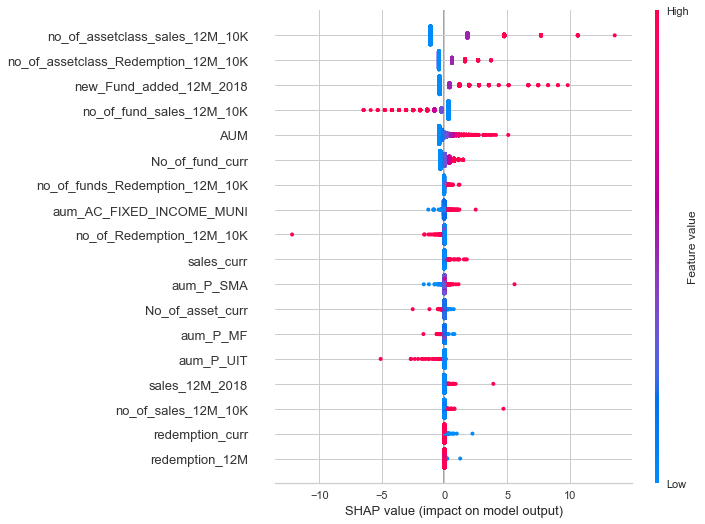

In [655]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_test_prepared)

In [656]:
predict_proba = pd.DataFrame(log_model.predict_proba(X_test_prepared))
predict_proba.head()

,0,1
0,0.853847,0.146153
1,0.818772,0.181228
2,0.825113,0.174887
3,0.812097,0.187903
4,0.788817,0.211183


In [657]:
pred_log = pd.DataFrame(pred_log)

In [658]:
auc_score = metrics.roc_auc_score( predictions.actual, predictions.predicted )
round( float( auc_score ), 2 )

0.52

# Scratch Work

In [659]:
import scikitplot as skplt

In [660]:
test_pred_proba = gbt_base2.predict_proba(X_test_prepared)

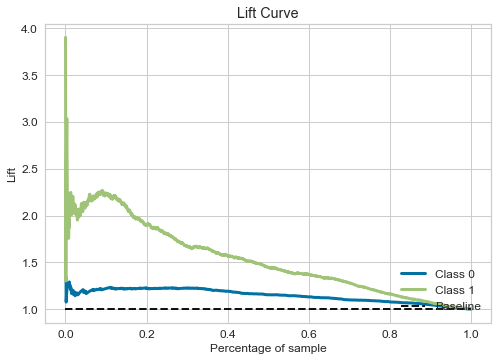

In [661]:
skplt.metrics.plot_lift_curve(y_test_cl, test_pred_proba);

# Cross Validation

In [662]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score

In [663]:
scoring = ['neg_root_mean_squared_error']

# Feature Engineering

In [664]:
X_train_prepared.corr().style.background_gradient().set_precision(2)

,no_of_sales_12M_10K,no_of_Redemption_12M_10K,no_of_fund_sales_12M_10K,no_of_funds_Redemption_12M_10K,no_of_assetclass_sales_12M_10K,no_of_assetclass_Redemption_12M_10K,AUM,No_of_fund_curr,No_of_asset_curr,sales_curr,sales_12M_2018,redemption_curr,redemption_12M,new_Fund_added_12M_2018,aum_AC_FIXED_INCOME_MUNI,aum_P_MF,aum_P_SMA,aum_P_UIT
no_of_sales_12M_10K,1.00,0.67,0.61,0.55,0.47,0.41,0.38,0.26,0.29,0.40,0.59,-0.36,-0.44,0.26,0.24,0.25,0.16,0.02
no_of_Redemption_12M_10K,0.67,1.00,0.45,0.58,0.35,0.45,0.29,0.18,0.18,0.42,0.44,-0.38,-0.64,0.13,0.22,0.14,0.14,0.00
no_of_fund_sales_12M_10K,0.61,0.45,1.00,0.68,0.84,0.57,0.65,0.49,0.21,0.25,0.42,-0.24,-0.31,0.54,0.17,0.16,0.14,0.03
no_of_funds_Redemption_12M_10K,0.55,0.58,0.68,1.00,0.58,0.86,0.56,0.37,0.17,0.27,0.37,-0.27,-0.39,0.29,0.16,0.13,0.13,0.03
no_of_assetclass_sales_12M_10K,0.47,0.35,0.84,0.58,1.00,0.60,0.59,0.56,0.18,0.16,0.31,-0.16,-0.25,0.43,0.15,0.14,0.12,0.03
no_of_assetclass_Redemption_12M_10K,0.41,0.45,0.57,0.86,0.60,1.00,0.53,0.41,0.15,0.14,0.26,-0.18,-0.30,0.26,0.13,0.11,0.10,0.04
AUM,0.38,0.29,0.65,0.56,0.59,0.53,1.00,0.78,0.24,0.17,0.27,-0.16,-0.22,0.37,0.18,0.16,0.15,0.17
No_of_fund_curr,0.26,0.18,0.49,0.37,0.56,0.41,0.78,1.00,0.21,0.10,0.18,-0.09,-0.12,0.30,0.13,0.14,0.15,0.11
No_of_asset_curr,0.29,0.18,0.21,0.17,0.18,0.15,0.24,0.21,1.00,0.27,0.67,-0.15,-0.39,0.09,0.86,0.88,0.48,0.03
sales_curr,0.40,0.42,0.25,0.27,0.16,0.14,0.17,0.10,0.27,1.00,0.38,-0.34,-0.38,0.09,0.28,0.20,0.20,0.02


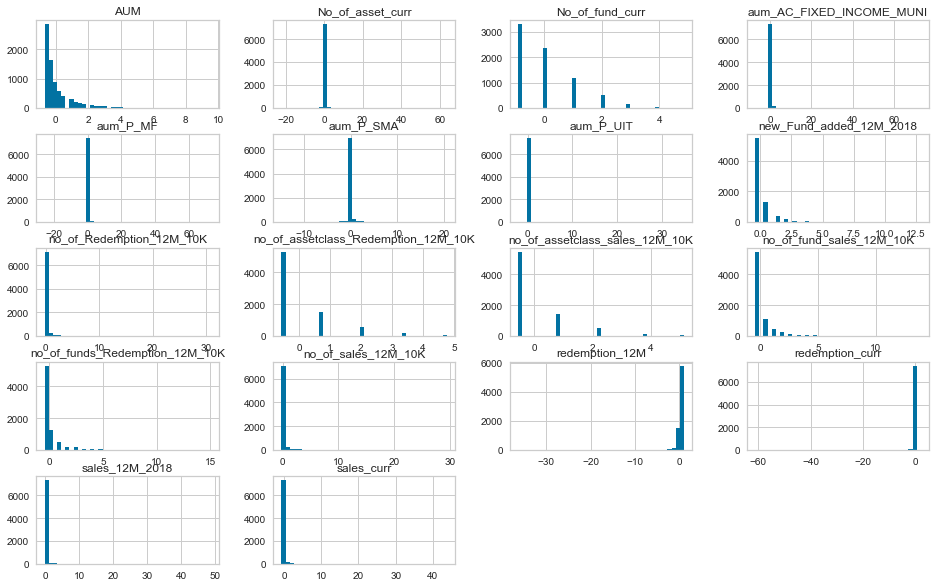

In [665]:
X_train_prepared.hist(bins=40, figsize=(16,10));

# Variable Inflation Factor (VIF)

In [666]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

class ReduceVIF(BaseEstimator, TransformerMixin):
    def __init__(self, thresh=10.0, impute=True, impute_strategy='median'):
        # From looking at documentation, values between 5 and 10 are "okay".
        # Above 10 is too high and so should be removed.
        self.thresh = thresh
        
        # The statsmodel function will fail with NaN values, as such we have to impute them.
        # By default we impute using the median value.
        # This imputation could be taken out and added as part of an sklearn Pipeline.
        if impute:
            self.imputer = SimpleImputer(strategy=impute_strategy)

    def fit(self, X, y=None):
        print('ReduceVIF fit')
        if hasattr(self, 'imputer'):
            self.imputer.fit(X)
        return self

    def transform(self, X, y=None):
        print('ReduceVIF transform')
        columns = X.columns.tolist()
        if hasattr(self, 'imputer'):
            X = pd.DataFrame(self.imputer.transform(X), columns=columns)
        return ReduceVIF.calculate_vif(X, self.thresh)

    @staticmethod
    def calculate_vif(X, thresh=5.0):
        # Taken from https://stats.stackexchange.com/a/253620/53565 and modified
        dropped=True
        while dropped:
            variables = X.columns
            dropped = False
            vif = [variance_inflation_factor(X[variables].values, X.columns.get_loc(var)) for var in X.columns]
            
            max_vif = max(vif)
            if max_vif > thresh:
                maxloc = vif.index(max_vif)
                print(f'Dropping {X.columns[maxloc]} with vif={max_vif}')
                X = X.drop([X.columns.tolist()[maxloc]], axis=1)
                dropped=True
        return X

In [667]:
funds = pd.concat([X_train_prepared, y_train_reg.to_frame()], axis=1)
features = funds.columns.tolist()
target = 'sales_12M_2019'

In [668]:
transformer = ReduceVIF()

X_tr_vif = transformer.fit_transform(X_train_prepared, y_train_reg)
X_tr_vif.head()

ReduceVIF fit
ReduceVIF transform
Dropping No_of_asset_curr with vif=92.07245085713294


,no_of_sales_12M_10K,no_of_Redemption_12M_10K,no_of_fund_sales_12M_10K,no_of_funds_Redemption_12M_10K,no_of_assetclass_sales_12M_10K,no_of_assetclass_Redemption_12M_10K,AUM,No_of_fund_curr,sales_curr,sales_12M_2018,redemption_curr,redemption_12M,new_Fund_added_12M_2018,aum_AC_FIXED_INCOME_MUNI,aum_P_MF,aum_P_SMA,aum_P_UIT
0,-0.213159,-0.202310,-0.431731,-0.451524,-0.539912,-0.566298,-0.688081,-0.887018,-0.087693,-0.158849,0.090594,0.151819,-0.412074,-0.090999,-0.065685,-0.074575,-0.069496
1,-0.213159,-0.092965,-0.431731,0.284471,-0.539912,0.770265,1.221427,3.897522,-0.087693,-0.143764,0.041500,0.123349,0.418829,-0.064646,-0.070373,0.157046,0.002049
2,-0.213159,-0.202310,-0.431731,-0.451524,-0.539912,-0.566298,-0.688081,-0.887018,-0.087693,-0.158849,0.090594,0.151819,-0.412074,-0.090999,-0.065685,-0.074575,-0.069496
3,-0.033034,0.125726,0.323874,1.020467,0.876508,2.106828,2.176180,1.026798,-0.087693,0.112938,0.090594,-0.282954,-0.412074,0.033916,0.333631,-1.522416,-0.069496
4,-0.213159,-0.202310,-0.431731,-0.451524,-0.539912,-0.566298,-0.688081,-0.887018,-0.087693,-0.158849,0.090594,0.151819,-0.412074,-0.090999,-0.065685,-0.074575,-0.069496
